### Implements algorithm 1 in the parti-game [paper](https://link.springer.com/content/pdf/10.1007/BF00993591.pdf)

Learn a controller from a start region to a goal region on a continuous space; Four increasingly effective algorithms to partition discrete state spaces. Algorithm 1 and 2 are non-learning; 3 and 4 learn, hence explore, the world while planning a route to the goal. Here, I implement algorithm 1

In [2]:
import sys
import numpy as np
from os.path import abspath, join
sys.path.append(abspath(join('..')))
sys.path.append(abspath(join('..', 'grids')))
sys.path.append(abspath(join('..', 'utils')))
sys.path.append(abspath(join('..', 'Visualization')))
sys.path.append(abspath(join('..')))

from grids import *
import matplotlib.pyplot as plt
from gen_utils import *
from BoundaryCondition import *
from Visualization import Visualizer
from valFuncs import proj
%matplotlib inline

In [3]:
from math import pi

grid_min = expand(np.array((-5, -5, -pi)), ax = 1); # Lower corner of computation domain
grid_max = expand(np.array((5, 5, pi)), ax = 1);   # Upper corner of computation domain
N = expand(np.array((41, 41,  41)), ax = 1);        # Number of grid points per dimension
pdDims = 3;               # 3rd dimension is periodic
g = createGrid(grid_min, grid_max, N, pdDims);

Did notcheck if entries are function handles


<Figure size 2160x1296 with 0 Axes>

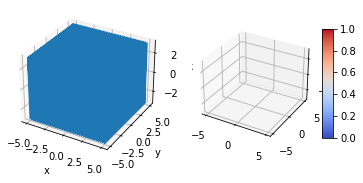

In [4]:
viz = Visualizer(winsize=(30, 18), fontdict={'fontsize':12, 'fontweight':'bold'})
viz.visGrid(g, 'red')

In [5]:
def sepGrid(g, dims):
    """
        gs = sepGrid(g, dims)
       Separates a grid into the different dimensions specified in dims

     Inputs:
       g    - grid
       dims - cell structure of grid dimensions
                eg. {[1 3], [2 4]} would split the grid into two; one grid in
                    the 1st and 3rd dimensions, and another in the 2nd and 4th
                    dimensions

     Output:
       gs - cell vector of separated grids
   """
    gs = [[] for  i in range(len(dims))]
    #dims = [[0, 2], [1, 3]]
    for i in range(len(gs)):
        dims_i = ones(1, g.dim);
        for j in dims[i]:
            dims_i[0, j] = 0
        gs[i] = proj(g, None, dims_i);

    return gs

In [6]:
# def sepGrid_test():
gridIn=expand(np.array((0, 1, 0, 1)), 1)
gridOut =expand(np.array((1, 2, 1, 2)), 1)
N = 45*ones(4,1).astype(np.int64)
g = createGrid(gridIn, gridOut, N);


gs = sepGrid(g, [[0, 2], [1, 3]]);
# Visualize
colors = ['blue', 'red', ];
for i in range(len(gs)):
    viz.visGrid(gs[i], colors[i])
    
dims = [[0, 2], [1, 3]]
gs = [[] for  i in range(len(dims))]
for i in range(len(gs)):
    dims_i = ones(1, g.dim);
    for j in dims[i]:
        dims_i[0, j] = 0
    gs[i]=proj()    

Did notcheck if entries are function handles


NameError: name 'gs' is not defined

In [34]:
xs = '100'
np.char.isnumeric(xs)

array(True)